In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from itertools import combinations
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomNodeSplit
from sklearn.preprocessing import OneHotEncoder
import re

In [2]:
import torch

# Check if GPU is available
print("CUDA Available:", torch.cuda.is_available())

# Get the name of the GPU
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8
Number of GPUs: 1


In [2]:
import numpy as np
import pandas as pd

def load_data(file_path):
    """
    Loads EEG dataset and identifies relevant columns.
    """
    df = pd.read_csv(file_path)
    target_col = "main.disorder"
    psd_columns = [col for col in df.columns if col.startswith("AB.")]
    coh_columns = [col for col in df.columns if col.startswith("COH.")]
    return df, target_col, psd_columns, coh_columns

def augment_psd(data, columns, target_col, noise_level=0.05):
    """
    Augments PSD values by adding Gaussian noise and increasing tail class counts.
    """
    class_counts = data[target_col].value_counts()
    max_samples = class_counts.max()
    augmented_data = data.copy()
    synthetic_samples = []
    
    column_std = data[columns].std()
    
    for disorder, count in class_counts.items():
        num_samples_needed = max_samples - count
        if num_samples_needed > 0:
            subset = data[data[target_col] == disorder]
            for _ in range(num_samples_needed):
                sample = subset.sample(n=1, replace=True).copy()
                noise = np.random.normal(loc=0, scale=noise_level * column_std, size=(1, len(columns)))
                sample[columns] += noise.flatten()
                synthetic_samples.append(sample)
    
    if synthetic_samples:
        augmented_data = pd.concat([augmented_data] + synthetic_samples, ignore_index=True)
    
    return augmented_data

def augment_coh(data, columns, target_col, noise_level=0.05):
    """
    Augments Coherence (FC) values by adding Gaussian noise and increasing tail class counts.
    """
    class_counts = data[target_col].value_counts()
    max_samples = class_counts.max()
    augmented_data = data.copy()
    synthetic_samples = []
    
    column_std = data[columns].std()
    
    for disorder, count in class_counts.items():
        num_samples_needed = max_samples - count
        if num_samples_needed > 0:
            subset = data[data[target_col] == disorder]
            for _ in range(num_samples_needed):
                sample = subset.sample(n=1, replace=True).copy()
                noise = np.random.normal(loc=0, scale=noise_level * column_std, size=(1, len(columns)))
                sample[columns] += noise.flatten()
                synthetic_samples.append(sample)
    
    if synthetic_samples:
        augmented_data = pd.concat([augmented_data] + synthetic_samples, ignore_index=True)
    
    return augmented_data

def preprocess_and_augment(file_path):
    """
    Loads dataset, applies augmentation, and returns processed data.
    """
    df, target_col, psd_columns, coh_columns = load_data(file_path)
    df = augment_psd(df, psd_columns, target_col)
    df = augment_coh(df, coh_columns, target_col)
    return df


In [3]:
# Load EEG dataset
data_path = 'data/train.csv'  # Update if necessary
df = preprocess_and_augment(data_path)

# Identify PSD and Coherence columns
psd_columns = [col for col in df.columns if col.startswith('AB.')]
coh_columns = [col for col in df.columns if col.startswith('COH.')]

# Extract unique electrodes from PSD column names
psd_electrodes = set()
for col in psd_columns:
    match = re.search(r'\.([A-Za-z0-9]+)$', col)
    if match:
        psd_electrodes.add(match.group(1))

# Extract unique electrodes from Coherence column names
coh_electrodes = set()
for col in coh_columns:
    match = re.search(r'COH\.[A-Za-z]+\.[A-Za-z]+\.[a-z]+\.([A-Za-z0-9]+)\.[a-z]+\.([A-Za-z0-9]+)', col)
    if match:
        coh_electrodes.add(match.group(1))
        coh_electrodes.add(match.group(2))

# Combine electrodes from PSD and Coherence
electrodes = sorted(psd_electrodes.union(coh_electrodes))

# Create a mapping for electrodes to indices
electrode_to_idx = {e: i for i, e in enumerate(electrodes)}
print(f" Extracted {len(electrodes)} unique electrodes.")

# Extract edges and weights using coherence values
edge_index = []
edge_weights = []
missing_electrodes = set()

for col in coh_columns:
    match = re.search(r'COH\.[A-Za-z]+\.[A-Za-z]+\.[a-z]+\.([A-Za-z0-9]+)\.[a-z]+\.([A-Za-z0-9]+)', col)
    if match:
        src, tgt = match.groups()
        if src in electrode_to_idx and tgt in electrode_to_idx:
            edge_index.append([electrode_to_idx[src], electrode_to_idx[tgt]])
            edge_weights.append(df[col].mean())
        else:
            missing_electrodes.add((src, tgt))

print(f" Successfully created {len(edge_index)} edges.")
print(f" Missing Electrodes for Edges: {missing_electrodes}")

# Convert edge list to tensor
if len(edge_index) > 0:
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
else:
    print(" Warning: No edges found!")

# Convert patient features (PSD & Coherence values)
num_patients = df.shape[0]
num_features_per_electrode = len(psd_columns) // len(electrodes)
patient_features = df[psd_columns].values.reshape(num_patients, len(electrodes), num_features_per_electrode)
patient_features_tensor = torch.tensor(patient_features, dtype=torch.float32)

# Extract labels
disorder_labels = df['main.disorder'].astype('category').cat.codes.values
target_tensor = torch.tensor(disorder_labels, dtype=torch.long)


# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
disorder_labels = df[['main.disorder']].astype('category')
disorder_labels_onehot = encoder.fit_transform(disorder_labels)
target_tensor = torch.tensor(disorder_labels_onehot, dtype=torch.float32)

ValueError: Unable to coerce to DataFrame, shape must be (1, 114): given (171, 114)

In [3]:
# Define GAT model for multiclass classification
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)
    
    def forward(self, x, edge_index, batch_size):
        out = []
        for i in range(batch_size):
            patient_x = x[i]
            patient_out = F.elu(self.conv1(patient_x, edge_index))
            patient_out = self.conv2(patient_out, edge_index)
            patient_out = patient_out.mean(dim=0)
            out.append(patient_out)
        out = torch.stack(out)
        return F.log_softmax(out, dim=1)

# Define training pipeline
in_channels = patient_features_tensor.shape[2]
hidden_channels = 16
out_channels = 7
model = GATModel(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


In [5]:
# # Training function

# model.to(device)

# # Move edge_index to GPU (assuming it doesn't change across batches)
# edge_index = edge_index.to(device)

# # Move entire dataset to GPU before training (optional, if memory allows)
# patient_features_tensor = patient_features_tensor.to(device)
# target_tensor = target_tensor.to(device)

def train():
    model.train()
    optimizer.zero_grad()
    batch_size = 128
    num_batches = num_patients // batch_size
    total_loss = 0
    
    for i in range(num_batches):
        batch_x = patient_features_tensor[i * batch_size : (i + 1) * batch_size]
        batch_y = target_tensor[i * batch_size : (i + 1) * batch_size]
        output = model(batch_x, edge_index, batch_size)
        loss = F.cross_entropy(output, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / num_batches

train_losses = []
val_losses = []
val_accuracies=[]
# Training loop
epochs = 100
for epoch in range(epochs):
    loss = train()
    train_losses.append(loss)  # Store training loss
    
    # Validation loss computation
    model.eval()
    with torch.no_grad():
        batch_x = patient_features_tensor[:32]  # Use a small validation set
        batch_y = target_tensor[:32]
        output = model(batch_x, edge_index, batch_size=32)
        val_loss = F.cross_entropy(output, batch_y.argmax(dim=1))
        val_losses.append(val_loss)
        
        # predicted = output.argmax(dim=1)
        # correct = (predicted == batch_y).sum().item()
        # val_accuracy = correct / len(batch_y) * 100  # Convert to percentage
        # val_accuracies.append(val_accuracy)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss:.4f}, Validation Loss {val_loss:.4f}")
torch.save(model.state_dict(), 'data/gat_eeg_model.pth')


Epoch 0: Train Loss 5.4007, Validation Loss 7.9314
Epoch 10: Train Loss 2.6536, Validation Loss 2.4067
Epoch 20: Train Loss 2.0227, Validation Loss 1.9767
Epoch 30: Train Loss 1.8632, Validation Loss 1.9447
Epoch 40: Train Loss 1.8488, Validation Loss 2.0181
Epoch 50: Train Loss 1.8428, Validation Loss 1.9492
Epoch 60: Train Loss 1.8287, Validation Loss 2.0307
Epoch 70: Train Loss 1.8102, Validation Loss 1.9463
Epoch 80: Train Loss 1.7865, Validation Loss 1.9998
Epoch 90: Train Loss 1.8791, Validation Loss 1.8730


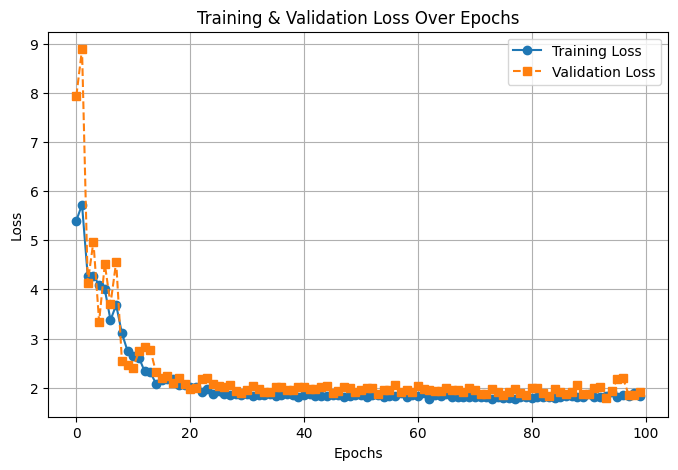

In [6]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), train_losses, label="Training Loss", marker="o", linestyle="-")
plt.plot(range(epochs), val_losses, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Define evaluation function
def evaluate(model, test_data_path, output_csv_path):
    test_df = pd.read_csv(test_data_path)
    test_patient_features = test_df[psd_columns].values.reshape(len(test_df), len(electrodes), num_features_per_electrode)
    test_patient_features_tensor = torch.tensor(test_patient_features, dtype=torch.float32)
    
    # One-hot encode test labels
    test_labels = test_df[['main.disorder']].astype('category')
    test_labels_onehot = encoder.transform(test_labels)
    test_labels_tensor = torch.tensor(test_labels_onehot, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        output = model(test_patient_features_tensor, edge_index, batch_size=len(test_df))
        predictions = output.argmax(dim=1).numpy()
        accuracy = (predictions == test_labels_tensor.argmax(dim=1).numpy()).sum().item() / len(test_df)
    
    print(f" Model Evaluation Accuracy: {accuracy:.4f}")
    
    # Save predictions to CSV
    test_df['predicted_disorder'] = encoder.categories_[0][predictions]
    test_df.to_csv(output_csv_path, index=False)
    print(f" Predictions saved to {output_csv_path}")
    
    return accuracy

# Load trained model and evaluate
test_data_path = 'data.csv'  
output_csv_path = 'data/predictions.csv'  
model.load_state_dict(torch.load('data/gat_eeg_model.pth'))
evaluate(model, test_data_path, output_csv_path)


 Model Evaluation Accuracy: 0.1935
 Predictions saved to data/predictions.csv


0.1935483870967742